In [12]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

def plotLoss(losses):
    plt.figure(dpi=90)
    plt.plot(losses, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def displayImage(image, label):
        plt.imshow(image.numpy().squeeze().reshape(28,28), cmap='gray')
        plt.title(label)
        plt.axis('off')

def displaySamples(n, **rows):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        j = 0
        for key, value in rows.items():
            plt.subplot(len(rows), n, i + n*j + 1)
            displayImage(value[i], key)
            j += 1
    plt.show()

def numberToOneHot(labels, num_classes):
    
    one_hot_labels = torch.zeros((labels.shape[0], num_classes)).to(labels.device)
    
    one_hot_labels.scatter_(1, labels.unsqueeze(1), 1)
    
    return one_hot_labels.to(device)

class ModelPersistence:
    @staticmethod
    def load(model):
        result = model().to(device)
        state_dict = torch.load(result.path)
        result.load_state_dict(state_dict)
        return result
    
    @staticmethod
    def save(model):
        torch.save(model.state_dict(), model.path)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(torch.flatten)
])

batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [14]:
class Encoder(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),     
            nn.Linear(512, 256),
            nn.ReLU(),     
            nn.Linear(256, 128),
            nn.Sigmoid(),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/encoder.pth'

    def forward(self, x):
        x = self.layers(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Decoder, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),     
            nn.Linear(256, 512),  
            nn.ReLU(),     
            nn.Linear(512, 784),  
            nn.Sigmoid(),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/decoder.pth'

    def forward(self, x):
        x = self.layers(x)
        return x
    
class Denoiser(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Denoiser, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),     
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/denoiser.pth'

    def forward(self, x):
        x = self.layers(x)
        return x

100%|██████████| 938/938 [00:04<00:00, 214.15it/s]


Epoch [1/10], Loss: 0.0336


100%|██████████| 938/938 [00:04<00:00, 227.28it/s]


Epoch [2/10], Loss: 0.0211


100%|██████████| 938/938 [00:04<00:00, 231.95it/s]


Epoch [3/10], Loss: 0.0155


100%|██████████| 938/938 [00:03<00:00, 235.86it/s]


Epoch [4/10], Loss: 0.0152


100%|██████████| 938/938 [00:04<00:00, 231.72it/s]


Epoch [5/10], Loss: 0.0128


100%|██████████| 938/938 [00:03<00:00, 244.17it/s]


Epoch [6/10], Loss: 0.0118


100%|██████████| 938/938 [00:03<00:00, 235.14it/s]


Epoch [7/10], Loss: 0.0101


100%|██████████| 938/938 [00:04<00:00, 232.57it/s]


Epoch [8/10], Loss: 0.0110


100%|██████████| 938/938 [00:03<00:00, 239.07it/s]


Epoch [9/10], Loss: 0.0081


100%|██████████| 938/938 [00:03<00:00, 234.56it/s]

Epoch [10/10], Loss: 0.0072


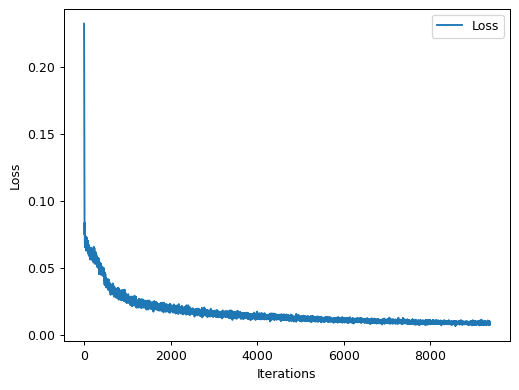

In [15]:
learning_rate = 0.001
epochs = 10

encoder = Encoder(learning_rate).to(device)
decoder = Decoder(learning_rate).to(device)
criterion = nn.MSELoss()

losses = []

for epoch in range(epochs):
    for data in tqdm(train_loader):
        
        images, _ = data

        images = images.to(device)

        encoder.zero_grad()
        decoder.zero_grad()
        
        encodedImages = encoder(images)
        outputs = decoder(encodedImages)

        loss = criterion(outputs, images)

        loss.backward()
        losses.append(loss.item())
        encoder.optimizer.step()
        decoder.optimizer.step()

    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

ModelPersistence.save(encoder)
ModelPersistence.save(decoder)

plotLoss(losses)

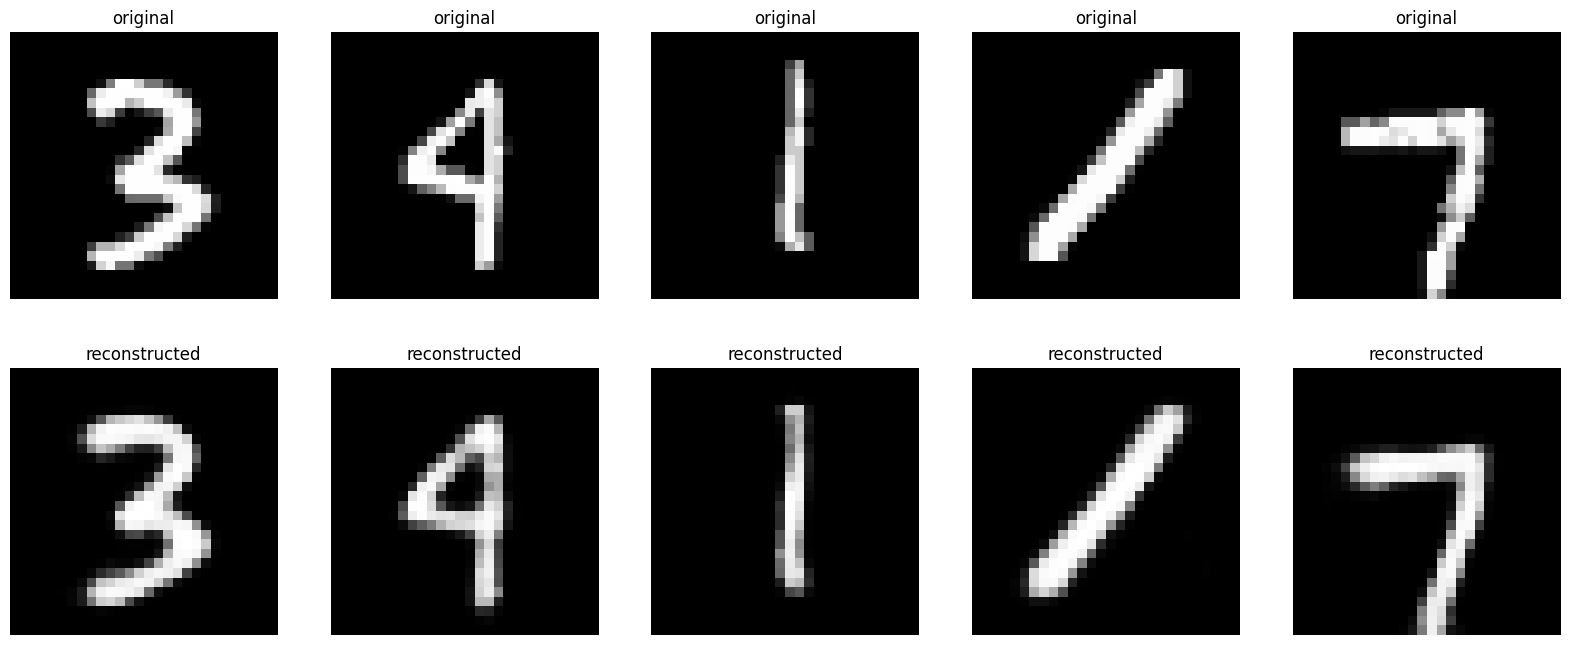

In [16]:
with torch.no_grad():
    test_images, _ = next(iter(train_loader))
    test_images = test_images.to(device)
    reconstructed_images = decoder(encoder(test_images))
    displaySamples(5, original=test_images.cpu(), reconstructed=reconstructed_images.cpu())

100%|██████████| 938/938 [00:04<00:00, 228.40it/s]


Epoch [1/10], Loss: 0.4726


100%|██████████| 938/938 [00:04<00:00, 226.62it/s]


Epoch [2/10], Loss: 0.4688


100%|██████████| 938/938 [00:04<00:00, 233.78it/s]


Epoch [3/10], Loss: 0.4688


100%|██████████| 938/938 [00:04<00:00, 222.75it/s]


Epoch [4/10], Loss: 0.4736


100%|██████████| 938/938 [00:03<00:00, 234.62it/s]


Epoch [5/10], Loss: 0.4771


100%|██████████| 938/938 [00:04<00:00, 221.17it/s]


Epoch [6/10], Loss: 0.4696


100%|██████████| 938/938 [00:04<00:00, 232.86it/s]


Epoch [7/10], Loss: 0.4704


100%|██████████| 938/938 [00:04<00:00, 224.13it/s]


Epoch [8/10], Loss: 0.4537


100%|██████████| 938/938 [00:04<00:00, 226.35it/s]


Epoch [9/10], Loss: 0.4731


100%|██████████| 938/938 [00:04<00:00, 232.80it/s]

Epoch [10/10], Loss: 0.4636


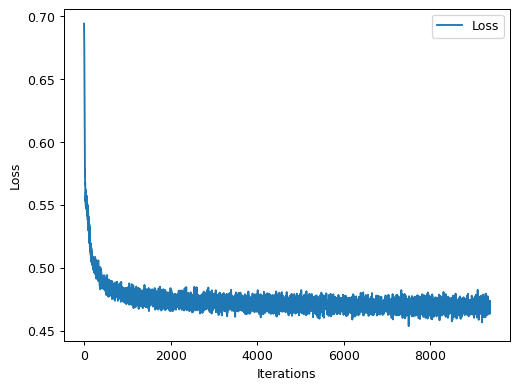

In [17]:
learning_rate = 0.001
epochs = 10

denoiser = Denoiser(learning_rate).to(device)
criterion = nn.BCELoss()

losses = []

for epoch in range(epochs):
    for data in tqdm(train_loader):
        
        images, labels = data
        oneHotLabels = numberToOneHot(labels,  10)
        images = images.to(device)
        denoiser.optimizer.zero_grad()
        
        encoded = encoder(images)
        noise = torch.randn_like(encoded) * 0.5
        predicted = denoiser((encoded+noise)/2)
        loss = criterion(predicted, encoded)
        loss.backward()
        losses.append(loss.item())
        denoiser.optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
ModelPersistence.save(denoiser)

plotLoss(losses)

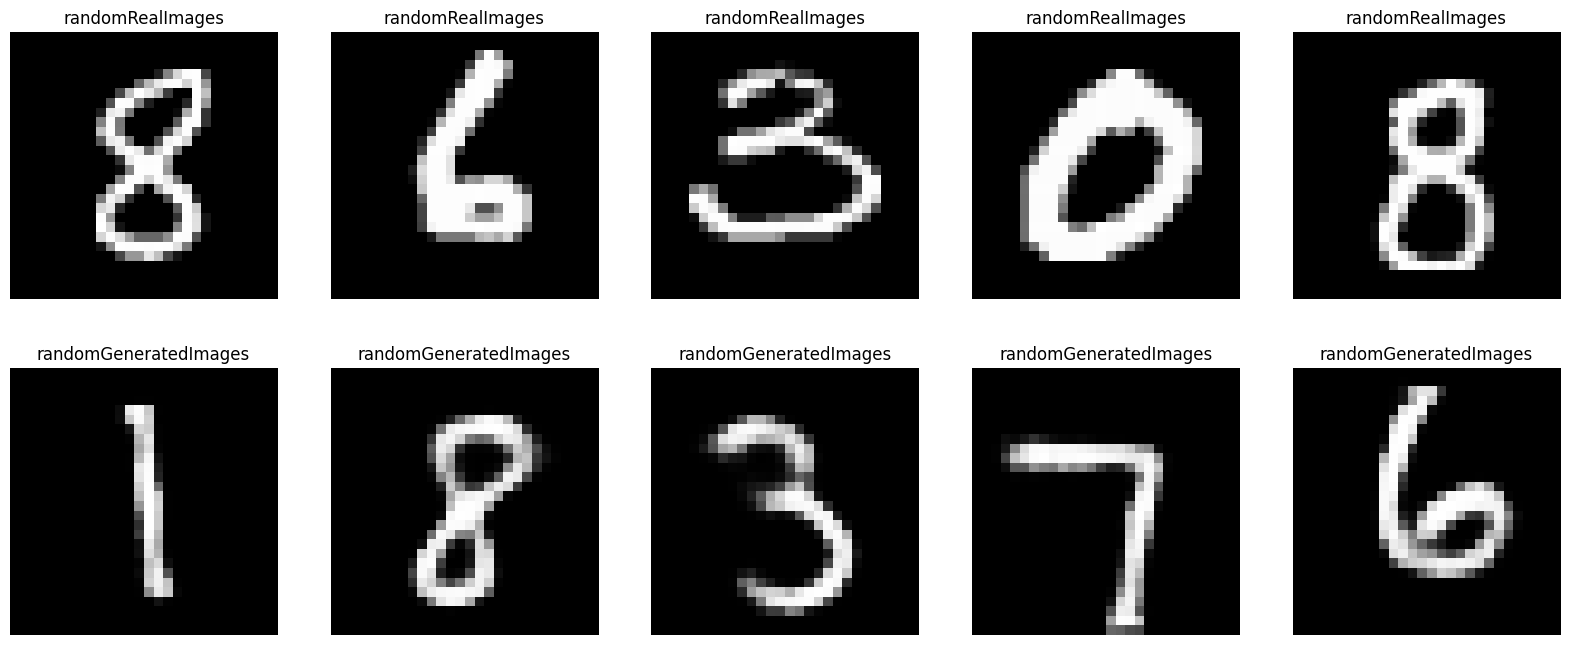

In [25]:
randomNoise = torch.randn((5, 128), device=device)

with torch.no_grad():
    
    test_images, _ = next(iter(train_loader))
    test_images = test_images.to(device)

    out = randomNoise
    for i in range(10):
        out = denoiser(out)

    generatedImages = decoder(out)

    displaySamples(5, randomRealImages=test_images.cpu(), randomGeneratedImages=generatedImages.cpu())

In [19]:
denoiser = ModelPersistence.load(Denoiser)
encoder = ModelPersistence.load(Encoder)
decoder = ModelPersistence.load(Decoder)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_18036\1521150663.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(result.path)
